# Single-Order Spectrum

This will show how to fit a single-order spectrum using our [previous setup](setup.ipynb) on [WASP14](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=wasp+14&submit=SIMBAD+search) TRES data.

<div class="alert alert-warning">
**Warning:** This documentation is a work in progress, please be aware this will change rapidly. 
</div>

In [1]:
%load_ext autoreload
%autoreload 2

## Preprocessing

So the first thing we need to do is pre-process our data. Here we loud the original dataset.

In [2]:
import h5py

with h5py.File('WASP14-2009-12-24.hdf5') as base:
    wls = base['wls'][:]
    fls = base['fls'][:]
    sigmas = base['sigmas'][:]

In [3]:
wls.shape

(51, 2298)

Now I'm going to select a single order to fit, and create a new `Spectrum`

In [43]:
from Starfish.spectrum import Spectrum

order = 22
wave = wls[order]
flux = fls[order]
sigma = sigmas[order]
# Remove errant absorption. See full dataset for more info
mask = flux < 1e-13 

data = Spectrum(wave, flux, sigma, mask, name=f'WASP 14: Order {order}')
data.save('WASP14_o22.hdf5')

And lets take a look at our data

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['text.usetex'] = True

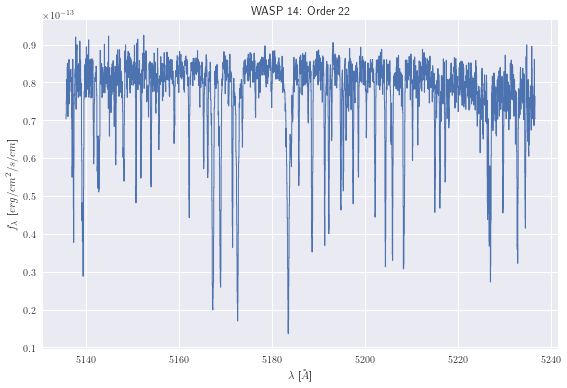

In [51]:
plt.step(data.waves, data.fluxes, lw=1)
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.ylabel(r'$f_\lambda$ [$erg/cm^2/s/cm$]')
plt.title(f'WASP 14: Order {order}')
plt.tight_layout()

## Setting up the model

Now we can set up our initial model. We need, at minimum, an emulator, our data, and a set of the library grid parameters. Every extra keyword argument we add is added to our list of parameters. For more information on what parameters are available and what effect they have, see the [SpectrumModel documentation](). 

Some of these parameters are based on guesses or pre-existing knowledge. In particular, it's important to tune `log_scale` to a reasonable value, so take some iterations of plotting against the data to get a good starting point.

In [191]:
from Starfish.emulator import Emulator
from Starfish.models import SpectrumModel

emu = Emulator.load('F_TRES_emu.hdf5')
model = SpectrumModel(
    emu, 
    data, 
    grid_params=[6300, 4.29, -0.5],
    log_scale=-13.2,
    vz = 0,
    vsini = 2,
    Av = 0.0,
#     glob=dict(log_amp=-68, log_ls=2)
)
model

SpectrumModel
-------------
Data: WASP 14: Order 22
Parameters:
	T: 6300
	logg: 4.29
	Z: -0.5
	log_scale: -13.2
	vz: 0
	vsini: 2
	Av: 0.0

Log Likelihood: 41396.14

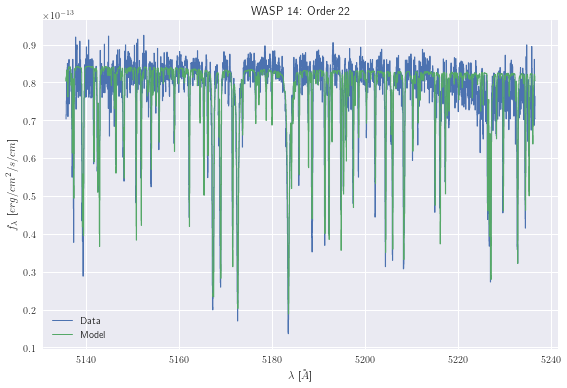

In [192]:
model_flux, model_cov = model()
plt.step(data.waves, data.fluxes, lw=1, label='Data')
plt.step(data.waves, model_flux, lw=1, label='Model')
plt.legend()
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.ylabel(r'$f_\lambda$ [$erg/cm^2/s/cm$]')
plt.title(f'WASP 14: Order {order}')
plt.tight_layout()

## Numerical Optimization

Now lets do a *maximum a posteriori* (MAP) point estimate for our data. Note that we freeze `logg` here because the PHOENIX models' response to `logg` compared to our data are relatively flat, so we fix the value using the [freeze]() mechanics.

In [193]:
model.freeze('logg')
# These are the fittable parameters
model.labels

['T', 'Z', 'log_scale', 'vz', 'vsini', 'Av']

In [194]:
from scipy.optimize import minimize
import scipy.stats as st
import numpy as np

priors = {
    'T': st.uniform(5900, 1300),
    'Z': st.uniform(-1, 1),
    'log_scale': st.norm(-13.2, 0.5),
    'vsini': st.uniform(2, 1e4),
    'Av': st.halfnorm(0, 0.5)
}

def nll(P, loglikes):
    model.set_param_vector(P)
    ll = np.sum([priors[key].logpdf(val) for key, val in zip(model.labels, P) if key in priors])
    if not np.isfinite(ll):
        return np.inf
    ll += model.log_likelihood()
    loglikes.append(ll)
    return -ll

P0 = model.get_param_vector()

In [197]:
ll = []
%time soln = minimize(nll, P0, args=(ll,), method='Nelder-Mead')
soln.message

CPU times: user 4min 17s, sys: 49.5 s, total: 5min 7s
Wall time: 1min 36s


'Optimization terminated successfully.'

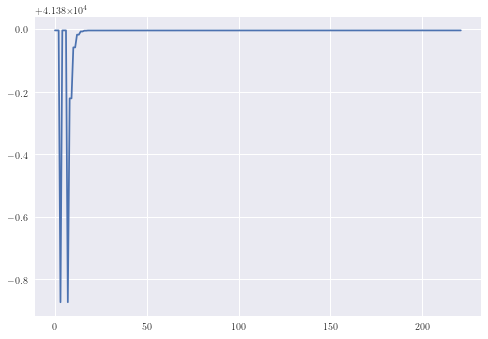

In [198]:
plt.plot(ll)

In [199]:
model.set_param_vector(soln.x)
model

SpectrumModel
-------------
Data: WASP 14: Order 22
Parameters:
	T: 6300.0
	logg: 4.29
	Z: -0.5
	log_scale: -13.2
	vz: 0.0
	vsini: 2.0
	Av: 0.0

Log Likelihood: 41396.14

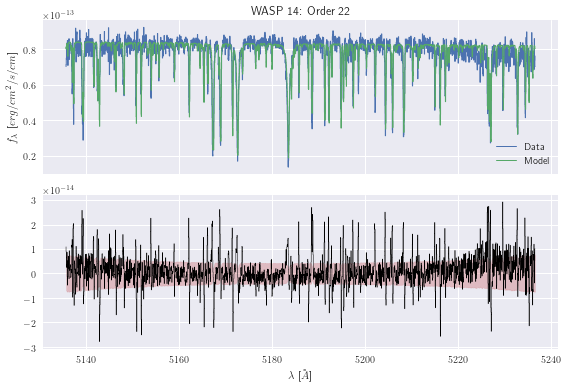

In [190]:
model_flux, model_cov = model()
std = np.sqrt(model_cov.diagonal())

fig, axes = plt.subplots(2, 1, sharex=True)
plt.sca(axes[0])
plt.step(data.waves, data.fluxes, lw=1, label='Data')
plt.step(data.waves, model_flux, lw=1, label='Model')
plt.legend()
plt.ylabel(r'$f_\lambda$ [$erg/cm^2/s/cm$]')
plt.title(f'WASP 14: Order {order}')

plt.sca(axes[1])
plt.step(data.waves, model_flux - data.fluxes, c='k', lw=.5)
plt.fill_between(data.waves, 2*std, -2*std, color='C2', alpha=0.3)
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.tight_layout()

In [200]:
model.log_likelihood()

41396.135917400796

In [203]:
model['T'] = 5900
model['Z'] = -1
model['log_scale'] = -13
model.log_likelihood()

41396.13591739042

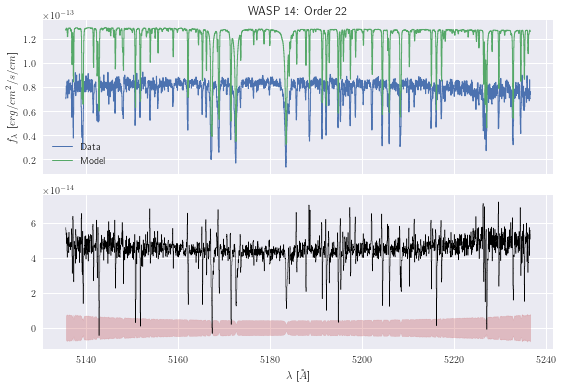

In [204]:
model_flux, model_cov = model()
std = np.sqrt(model_cov.diagonal())

fig, axes = plt.subplots(2, 1, sharex=True)
plt.sca(axes[0])
plt.step(data.waves, data.fluxes, lw=1, label='Data')
plt.step(data.waves, model_flux, lw=1, label='Model')
plt.legend()
plt.ylabel(r'$f_\lambda$ [$erg/cm^2/s/cm$]')
plt.title(f'WASP 14: Order {order}')

plt.sca(axes[1])
plt.step(data.waves, model_flux - data.fluxes, c='k', lw=.5)
plt.fill_between(data.waves, 2*std, -2*std, color='C2', alpha=0.3)
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.tight_layout()